# **RUL aircraft engine forecast**
See https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository, sample 6, for details on the data.

In [ ]:
## Install the packages (it may take a few minutes)

install.packages('neuralnet');require(neuralnet)
install.packages('MASS');require(MASS)
install.packages('corrplot');require(corrplot)
install.packages('depmixS4');require(depmixS4)
install.packages('smooth');require(smooth)
install.packages('rpart');require(rpart)
install.packages('e1071');require(e1071)
install.packages('class');require(class)
install.packages('randomForest');require(randomForest)
install.packages('LPCM');require(LPCM)


In [ ]:
## Download the data

download.file('https://raw.githubusercontent.com/antoinetordeux/RUL_predict_Turbofan/main/train_FD001.txt','/content/train_FD001.txt')


In [ ]:
## Read the data

X=read.table('train_FD001.txt')
unit=X[,1]
time=X[,2]
X=X[,6:26] #Sensor's data
names(X)=paste("X",1:21,sep="")


In [ ]:
## Total operating time ULv and UL (repeated) and remaining operating time RUL (time-dependent)

ULv=NULL
UL=NULL
RUL=NULL
for(u in unique(unit)){
	ULv=c(ULv,max(time[unit==u]))
	UL=c(UL,rep(max(time[unit==u]),length(time[unit==u])))
	RUL=c(RUL,max(time[unit==u])+1-time[unit==u])}


In [ ]:
## Reading out only the sensors providing information (i.e. variance greater than zero)

select=(1:ncol(X))[apply(X,2,var)>0]
X=X[,select]


## **Preliminary Data Analysis**

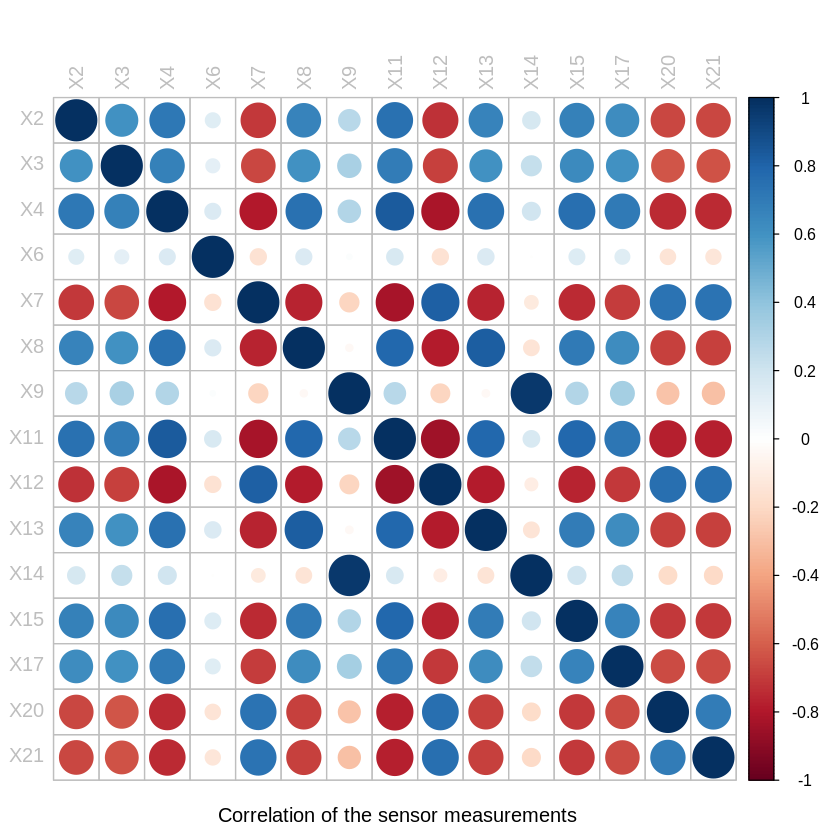

In [ ]:
## Autocorrelation of the sensor variables: the sensor measurements are highly correlated!

par(mar=c(4,4,4,2))
corrplot(cor(X),tl.cex=1,xlab="",tl.col="grey",title="")
text(8,0,"\n Correlation of the sensor measurements")


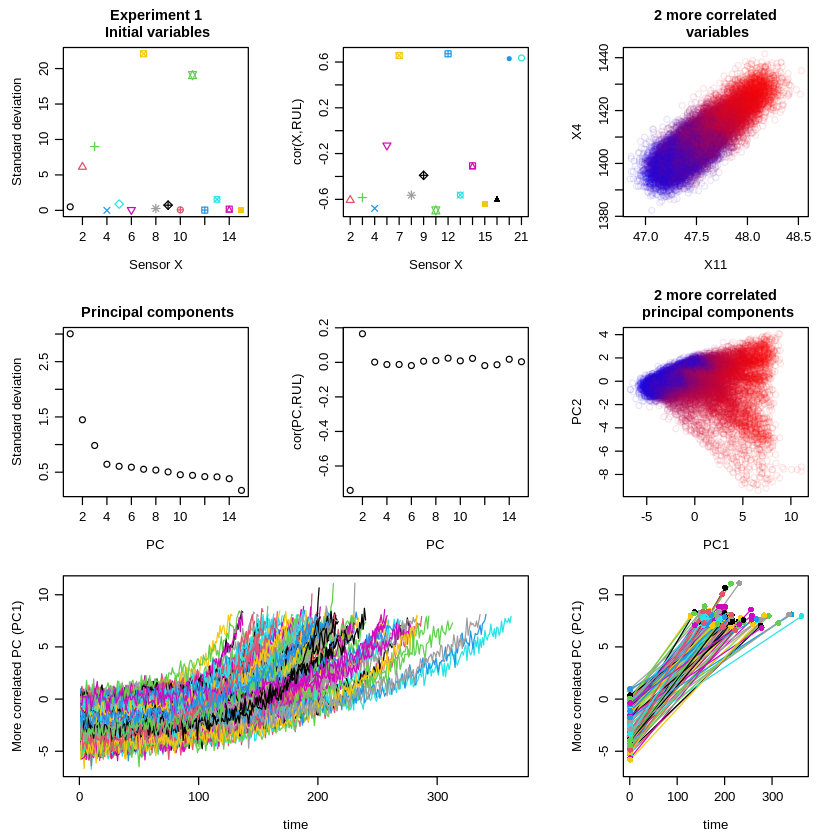

In [ ]:
## Preliminary data visualisation

layout(matrix(c(1,2,3,4,5,6,7,7,8),by=T,ncol=3))
par(mar=c(4,4,3,2),mgp=c(2.5,.75,0))

## Standard deviations of the sensor measurements
plot(apply(X,2,sd),main=paste("Experiment 1\n Initial variables"),pch=1:ncol(X),col=1:ncol(X),cex.main=1.1,ylab="Standard deviation",xlab="Sensor X")

## Correlations between sensor measurements and RUL
plot(cor(X,RUL),main=paste(""),pch=select,col=select,cex.main=1.1,ylab="cor(X,RUL)",xlab="Sensor X",xaxt='n',yaxt='n');axis(2);axis(1,1:ncol(X),select)

## Graph of the most correlated variables. Colours correspond to RUL: blue: large RUL, red: small RUL.
ordX=order(abs(cor(RUL,X)),decreasing=T)
plot(X[,ordX[1]],X[,ordX[2]],col=rgb(1-RUL/UL,0,RUL/UL,.1),main="2 more correlated\n variables",cex.main=1.1,xlab=paste("X",select[ordX[1]],sep=""),ylab=paste("X",select[ordX[2]],sep=""))

## The sensor measurements are highly correlated. We will analyse linear combinations of these variables using principal component analysis to reduce the dimensionality of the dataset.
PC=as.data.frame(prcomp(X,scale=T)$x)

## Graphical representation
plot(apply(PC,2,sd),main="\n Principal components",cex.main=1.1,ylab="Standard deviation",xlab="PC")
plot(cor(PC,RUL),cex.main=1.1,ylab="cor(PC,RUL)",xlab="PC")
ord=order(abs(cor(PC,RUL)),decreasing=T) # Layout of the components with the correlation to the RUL
plot(PC[,ord[1]],PC[,ord[2]],col=rgb(1-RUL/UL,0,RUL/UL,.1),main="2 more correlated\n principal components",cex.main=1.1,xlab=paste("PC",ord[1],sep=""),ylab=paste("PC",ord[2],sep=""))

## Most correlated principal component as a function of time for each unit
par(mar=c(4,4,1,2))
plot(NA,xlim=range(time),ylim=range(PC[,ord[1]]),xlab="time",ylab=paste("More correlated PC (PC",ord[1],")",sep=""))
for(u in unique(unit))
	lines(PC[unit==u,ord[1]],col=u)
plot(NA,xlim=range(time),ylim=range(PC[,ord[1]]),xlab="time",ylab=paste("More correlated PC (PC",ord[1],")",sep=""))
for(u in unique(unit))
	lines(c(1,length(PC[unit==u,ord[1]])),PC[unit==u,ord[1]][c(1,length(PC[unit==u,ord[1]]))],col=u)
for(u in unique(unit))
	lines(c(1,length(PC[unit==u,ord[1]])),PC[unit==u,ord[1]][c(1,length(PC[unit==u,ord[1]]))],col=u,type='p',pch=16)



## **Classification**

In [ ]:
## Graphic display function

plot_fct=function(class,m){
	plot(NA,xlim=range(time),ylim=range(PC[,ord[1]]),xlab="time",ylab="PC1")
	for(u in unique(unit))
		for(c in unique(class))
			lines(time[unit==u&class==c],PC[unit==u&class==c,ord[1]],col=2*c,pch=c)
	plot(PC[,ord[1]],PC[,ord[2]],col=2*class,pch=as.numeric(class),main=m,cex.main=1.1,xlab=paste("PC",ord[1],sep=""),ylab=paste("PC",ord[2],sep=""))}


In [ ]:
## Classification

nb_states=2
PC=as.data.frame(PC)
set.seed(1)

## K-Means
KM=kmeans(PC[,ord[1:3]],nb_states)$cluster

## Hidden-Markov-Model
f=list(as.formula(PC1~1),as.formula(PC2~1),as.formula(PC9~1))
algo_HMM=depmix(f,nstates=nb_states,data=as.data.frame(PC),ntimes=ULv,family=list(gaussian(),gaussian(),gaussian()))
HMM=fit(algo_HMM)
HMM=posterior(HMM,type='viterbi')$state


converged at iteration 22 with logLik: -88391.64 


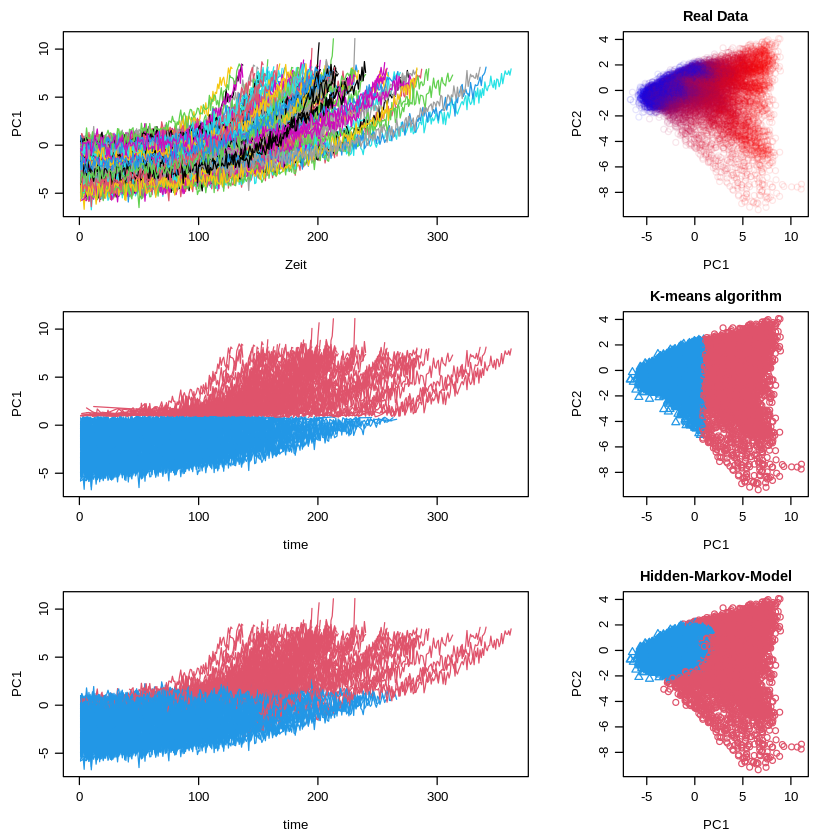

In [ ]:
## Plot the results

layout(matrix(c(1,1,2,3,3,4,5,5,6),by=T,ncol=3))
par(mar=c(4,4,2,2))
par(mgp=c(2.5,.75,0))
plot(NA,xlim=range(time),ylim=range(PC[,ord[1]]),main="",xlab="Zeit",ylab="PC1")
for(u in unique(unit))
	lines(PC[unit==u,ord[1]],col=u)
plot(PC[,ord[1]],PC[,ord[2]],col=rgb(1-RUL/UL,0,RUL/UL,.1),main="Real Data",cex.main=1.1,xlab=paste("PC",ord[1],sep=""),ylab=paste("PC",ord[2],sep=""))
plot_fct(KM,"K-means algorithm")
plot_fct(HMM,"Hidden-Markov-Model")


## **Prediction of RULs for the faulty state classified by HMM**

In [ ]:
## HMM classified faulty state

cc=HMM==1
if(mean(RUL[cc])>mean(RUL[!cc])) cc=HMM==2
XX=as.data.frame(PC[cc,ord[1:3]])
Y=RUL[cc]


In [ ]:
## MSE and R² error metrics

error=function(Yb,Y)
	c(mean((Yb-Y)^2),1-mean((Yb-Y)^2)/var(Y))


In [ ]:
## Cross-validation (80% of the data for training, 20% for testing)

train=NULL
train[1:nrow(XX)]=T
train[sample(1:nrow(XX),nrow(XX)/5)]=F
test=!train

## Lineare Regression
model_LM=glm(Y[train]~.,data=XX[train,])
LMtr=predict(model_LM,as.data.frame(XX[train,]))
LMte=predict(model_LM,as.data.frame(XX[test,]))

## Quadratische Regression
model_QM=glm(Y[train]^(1/2)~.,data=XX[train,])
QMtr=predict(model_QM,as.data.frame(XX[train,]))^2
QMte=predict(model_QM,as.data.frame(XX[test,]))^2

## Support-Vector-Machine
algo_SVM=svm(Y[train]~.,data=XX[train,])
SVMtr=predict(algo_SVM,XX[train,])
SVMte=predict(algo_SVM,XX[test,])

## Random-Forest
algo_RF=randomForest(Y[train]~.,data=XX[train,],ntree=100)
RFtr=predict(algo_RF,XX[train,])
RFte=predict(algo_RF,XX[test,])

## Feedforward neural network
algo_NN=neuralnet(as.formula(paste("Y[train]~",paste(names(XX),collapse="+"))),data=XX[train,],hidden=2,linear.output=T,threshold = .1,stepmax = 1e+07)
NNtr=round(as.vector(compute(algo_NN,XX[train,])$net.result))
NNte=round(as.vector(compute(algo_NN,XX[test,])$net.result))

## Mean value of the algorithms
MEANtr=apply(cbind(SVMtr,RFtr,NNtr),1,mean)
MEANte=apply(cbind(SVMte,RFte,NNte),1,mean)

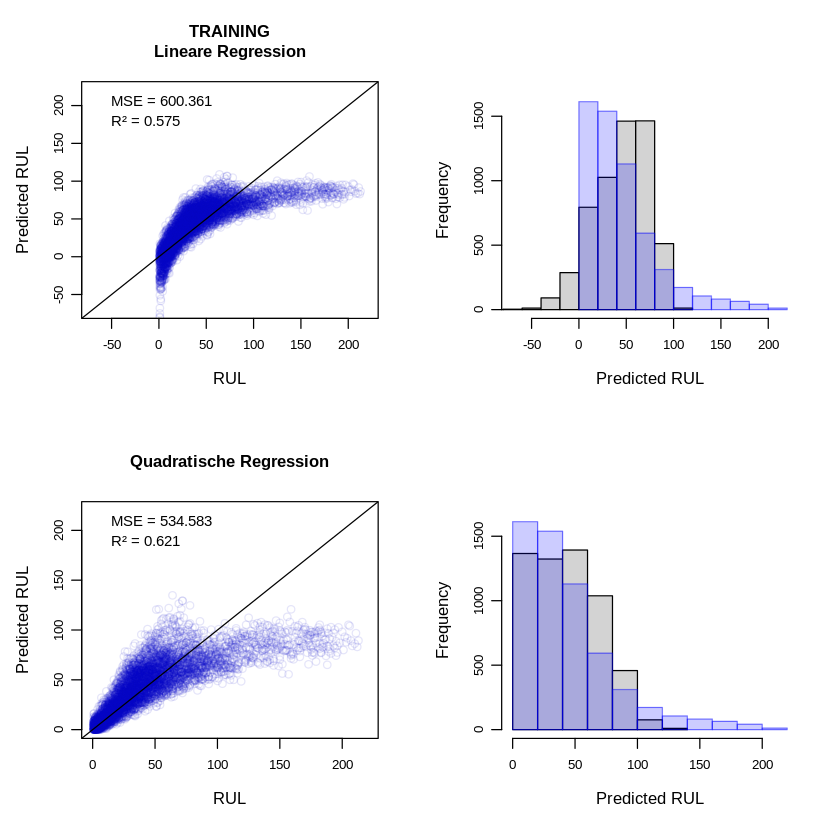

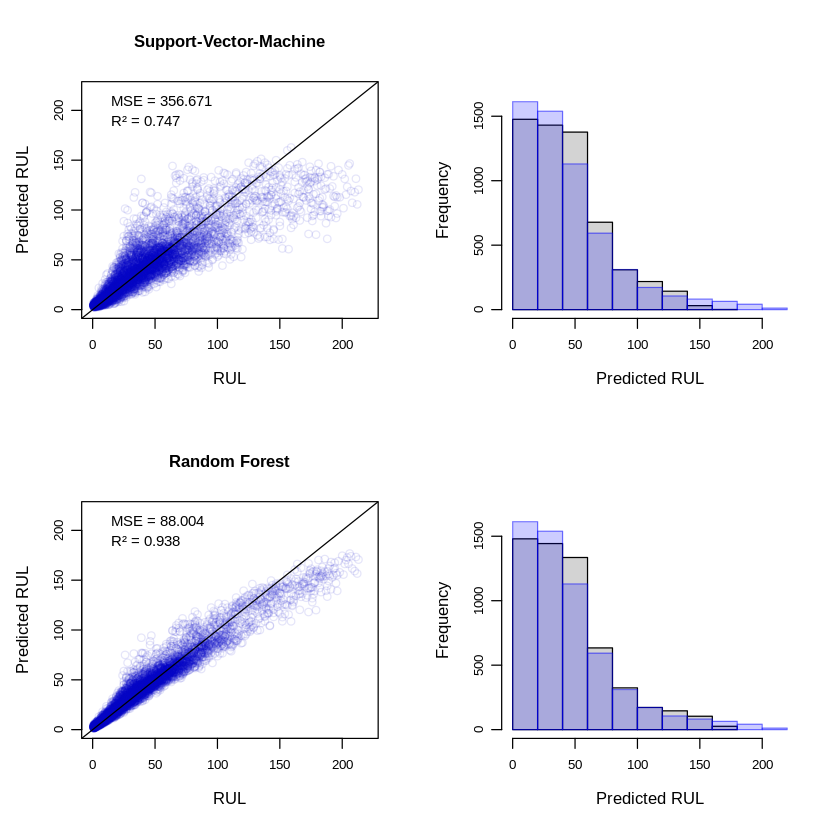

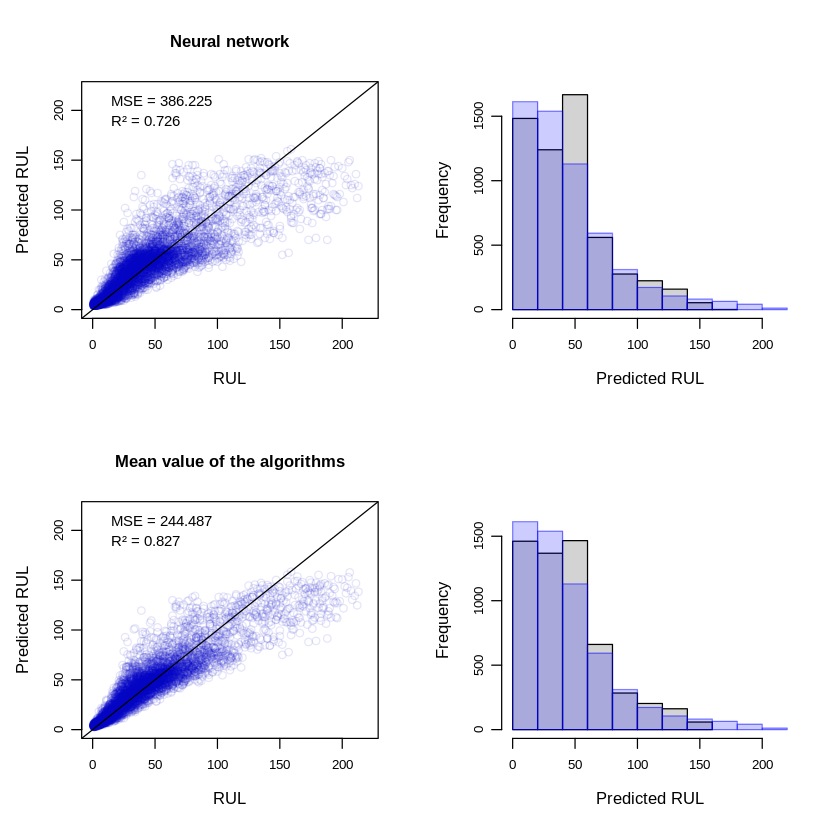

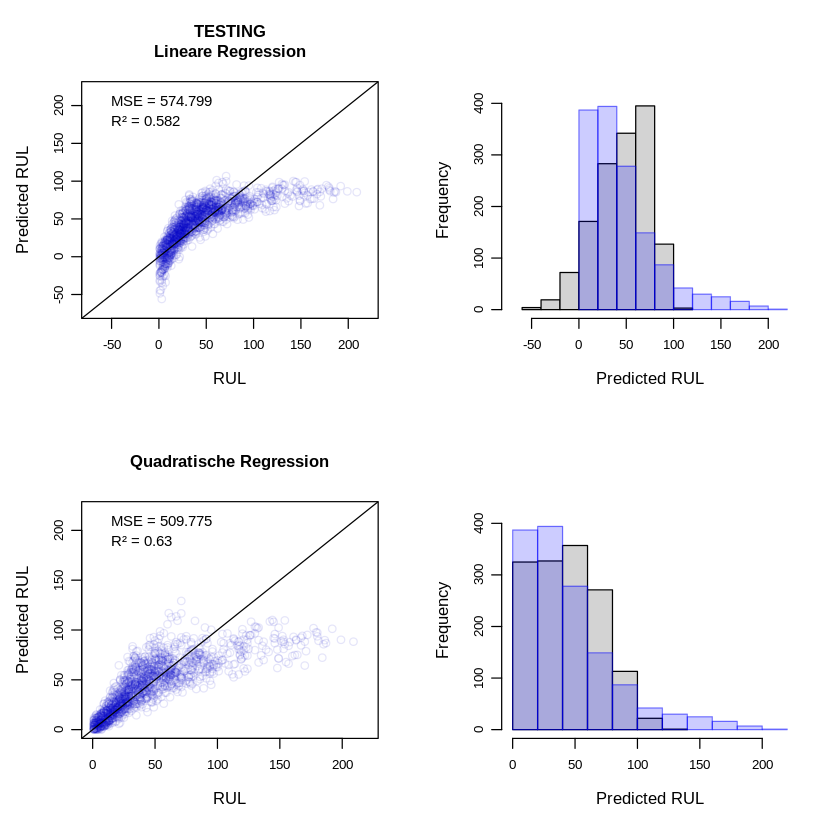

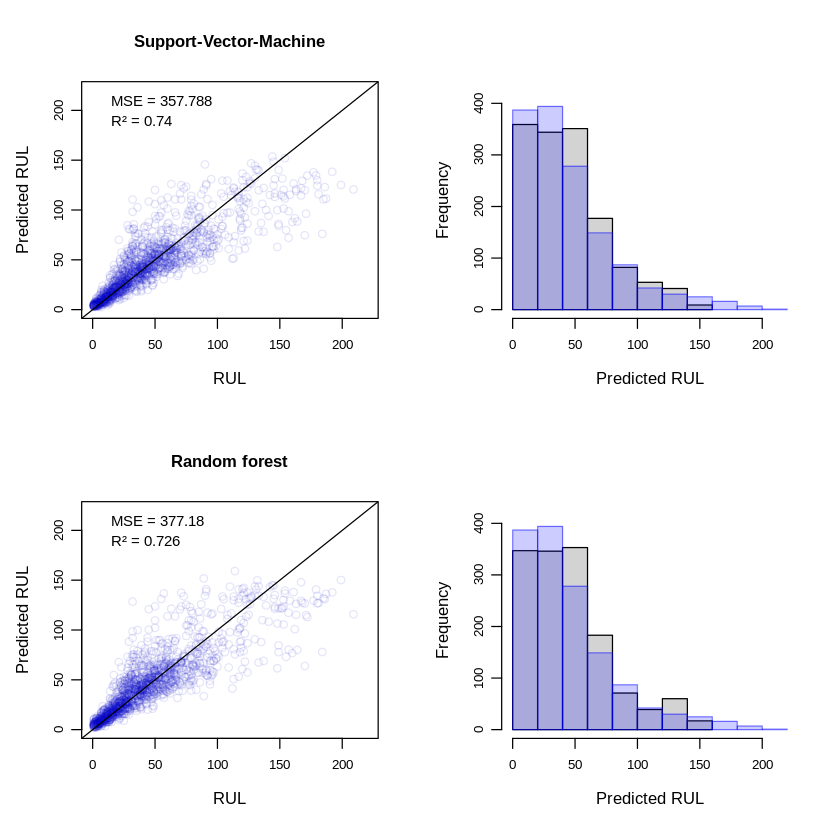

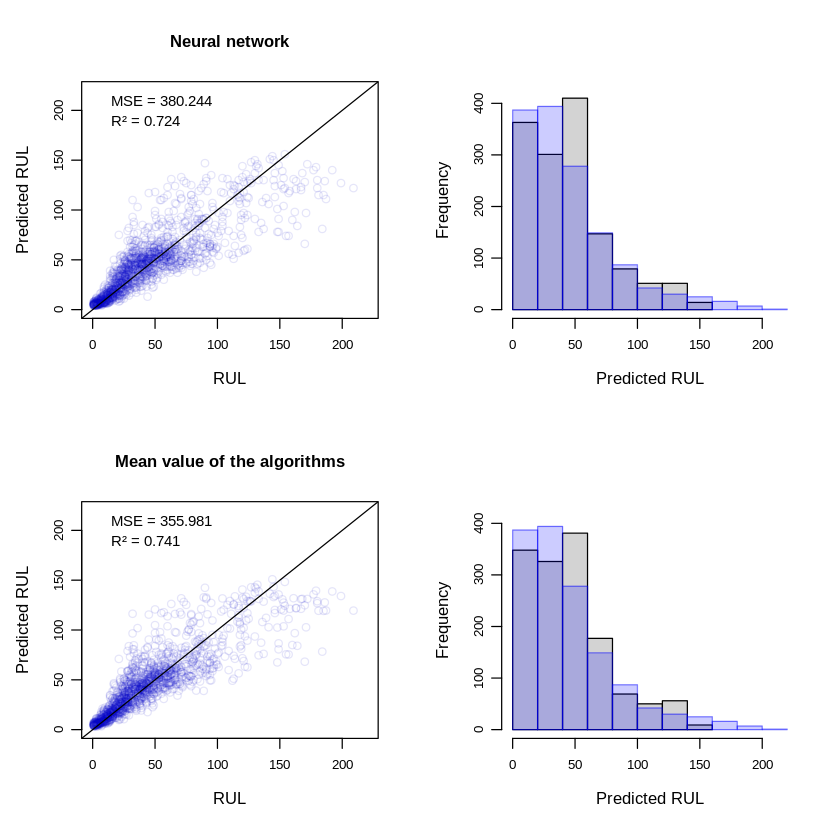

In [ ]:
## Plot the results

par(mfrow=c(2,2),mgp=c(2.5,.75,0))

plot_fct=function(Yb,Y,k,m){
	ll=c(0,220);if(k==6|k==12)ll=c(-70,220)
	plot(Y,Yb,xlim=ll,ylim=ll,col=rgb(0,0,.8,.1),xlab="RUL",ylab="Predicted RUL",main=m,cex.main=1,cex.axis=.8)
	legend("topleft",c(paste("MSE =",round(error(Yb,Y)[1],3)),paste("R² =",round(error(Yb,Y)[2],3))),cex=.9,bty='n')
	abline(b=1,a=0,col=1,lwd=1)
	ym=1700;if(k>11)ym=425
	hist(Yb,main="",xlab="Predicted RUL",ylab="Frequency",breaks=8,xlim=ll,ylim=c(0,ym),cex.axis=.8)
	hist(Y,add=T,col=rgb(0,0,1,.2),border=rgb(0,0,1,.5))}

plot_fct(LMtr,Y[train],6,"TRAINING\nLineare Regression")
plot_fct(QMtr,Y[train],7,"Quadratische Regression")
plot_fct(SVMtr,Y[train],8,"Support-Vector-Machine")
plot_fct(RFtr,Y[train],9,"Random Forest")
plot_fct(NNtr,Y[train],10,"Neural network")
plot_fct(MEANtr,Y[train],11,"Mean value of the algorithms")

plot_fct(LMte,Y[test],12,"TESTING\nLineare Regression")
plot_fct(QMte,Y[test],13,"Quadratische Regression")
plot_fct(SVMte,Y[test],14,"Support-Vector-Machine")
plot_fct(RFte,Y[test],15,"Random forest")
plot_fct(NNte,Y[test],16,"Neural network")
plot_fct(MEANte,Y[test],17,"Mean value of the algorithms")


##### Author: Antoine Tordeux, Bergische Universität Wuppertal ([vzu.uni-wuppertal.de](https://www.vzu.uni-wuppertal.de/en/))